## Python Notebook to interact with gym-battery and battery-agent

This python notebook is a working document to interact with and test the environment and the agent.

Note: In order for this to work, gym-battery needs to be installed as a package, using pip install -e gym-battery from wherever gym-battery exists.

The ipython notebook should exist in battery dispatch by default and should be ableto access those resources so it does not necessarily need to be build/installed using pip.

In [23]:
import gym
import gym_battery 
import numpy as np
import pandas as pd

In [24]:
env = gym.make('gym_battery:battery-v0', **{'N_actions':5})
env.set_standard_system()

setting the standard system, A10S Med busines large usage with a 2,000kW/10,000kWh battery


In [25]:
# Drop partial day one and add a low-load period for 2 hours at the start of each episode
import datetime
env.load.DF = env.load.DF[76:]
env.load.DF.value = [min(2800., r.value) if r.start.time() < datetime.time(2,0,0) else r.value for ix, r in env.load.DF.iterrows()]

array([   0.,    0., 2800., 2800.])

In [ ]:

env.episode_type = 'count_days'
env.run_N_episodes = 30

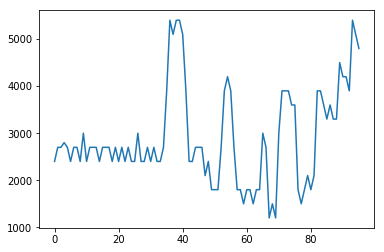

5400.0


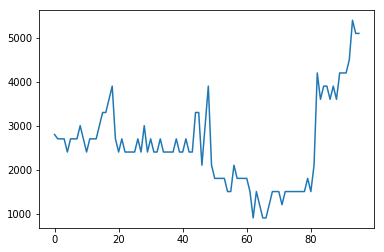

5400.0


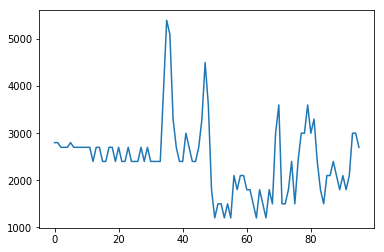

5400.0


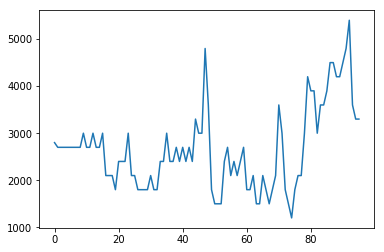

5400.0


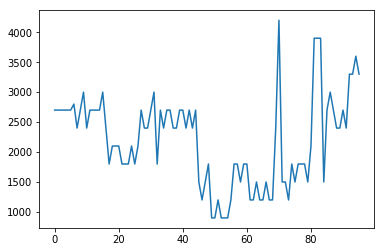

4200.0


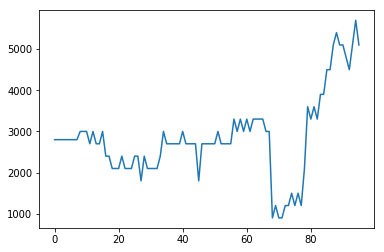

5700.0


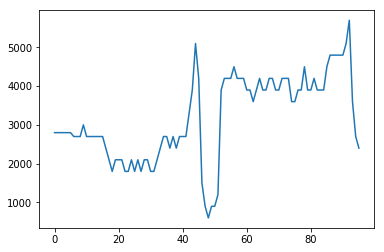

5700.0


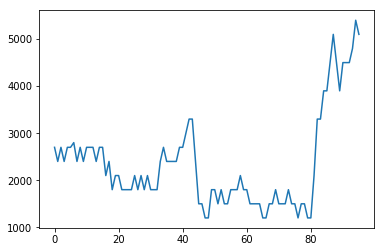

5400.0


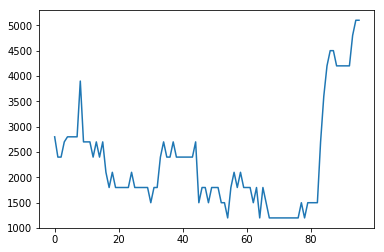

5100.0


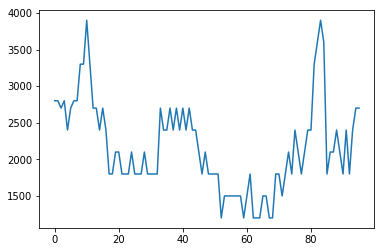

3900.0


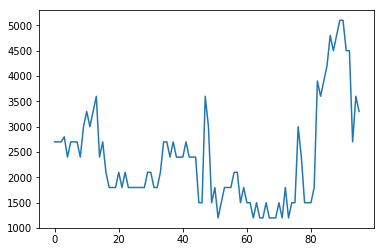

5100.0


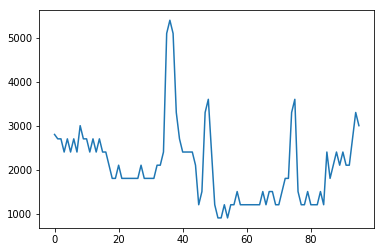

5400.0


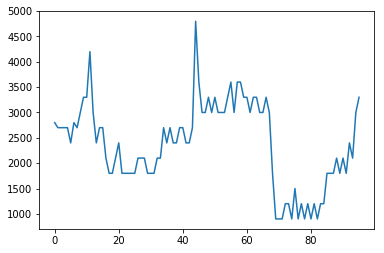

4800.0


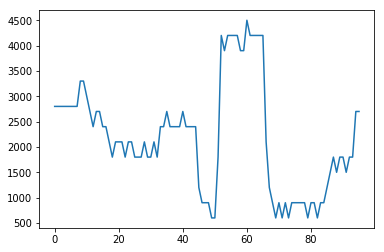

4500.0


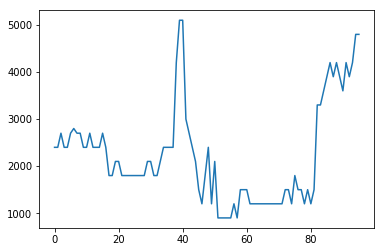

5100.0


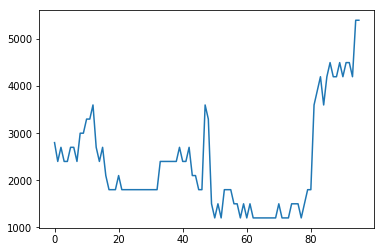

5400.0


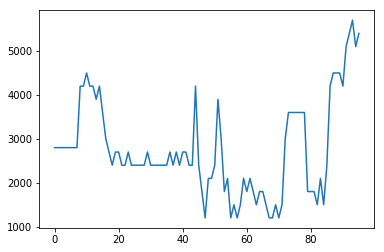

5700.0


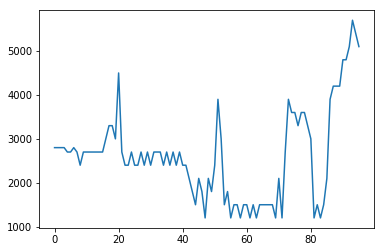

5700.0


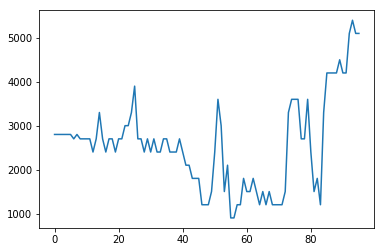

5400.0


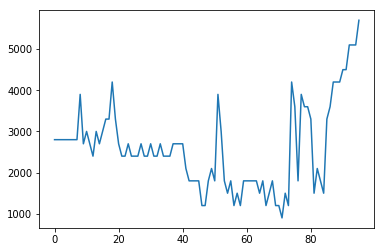

5700.0


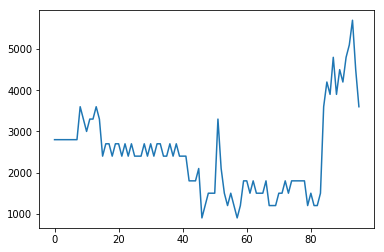

5700.0


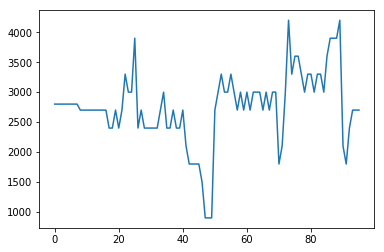

4200.0


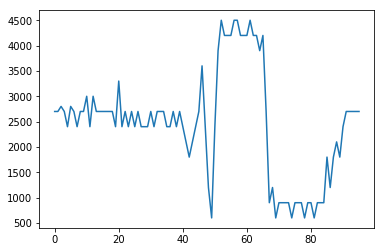

4500.0


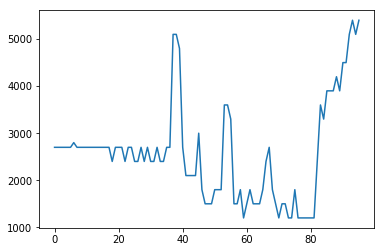

5400.0


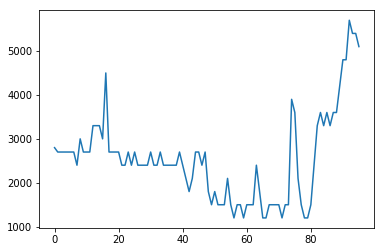

5700.0


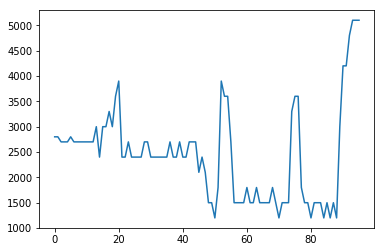

5100.0


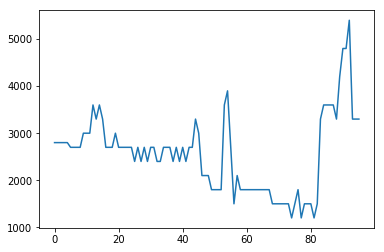

5400.0


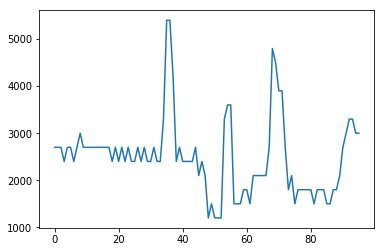

5400.0


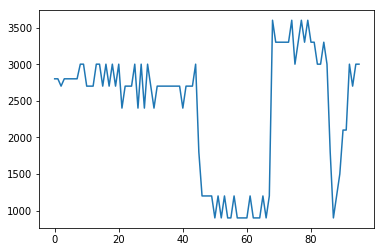

3600.0


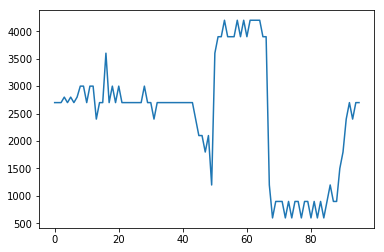

4200.0


In [33]:
import matplotlib.pyplot as plt


for i in range(30):
    env.reset()
    load = env.episode_DF
    plt.plot(list(load.value))
    plt.show()
    print(max(load.value))
plt.show()

In [27]:
print(env.observation_space.low)
print("to")
print(env.observation_space.high)

[  0.   0. 300. 300.]
to
[   24. 10000. 16200. 17200.]


In [ ]:
# Set how to structure the environment. 'count_days' will generate the a single day as an episode. THe number of days
# given indicates how many differnet days to use.
# This needs to be changed so that it generates LONGER episodes, not DIFFERENT episodes, but this hasn't been done yet.
env.episode_type = 'count_days'
env.run_N_episodes = 1
env.load.DF = env.load.DF[76:76+96]


In [ ]:
env.load.DF['value'][76] = 4500
DF_day1 = env.load.DF.copy()
DF_day1

In [ ]:
import pickle
simple_load = pd.read_pickle("simple_load_1d.pkl")
#simple_load = pd.read_clipboard()
simple_load.value.plot()
env.load.initialize(simple_load)
env.fit_load_to_space()

In [ ]:
DF_simple_day = env.load.DF.copy()
DF_simple_day

In [ ]:
DF_simple_day['day'] = 'simple_day'
DF_day1['day'] = 'day1'
DF_all = DF_simple_day.append(DF_day1)
DF_all.to_clipboard()
DF_all.shape

In [ ]:
# Get the do-nothing value for taking no action
def dict_key_by_val(d, val):
    for k in d.keys():
        if d[k] == val:
            return k
    raise ValueError("value not found in dictionary")
    
act0 = dict_key_by_val(env.action_mapping, 0)
act0

In [ ]:
''' Set up the agent and the discretizer.'''
from batterydispatch.agent.agents import MonteCarloAgent
from batterydispatch.agent.discretizers import Box_Discretizer

from batterydispatch.agent.policies import do_nothing
agent = MonteCarloAgent()
agent.set_policy(do_nothing, {'do_nothing_action': act0})

# Note, you can change the size of the state sapce by changing the number of buckets, below
agent.set_discretizer(Box_Discretizer(env.observation_space, N=[6, 4, 12, 12]))
agent.actions = env.action_space
agent.learning_rate = 0.05 # used for the updates of the Q estimates
agent.subtype = 'on-policy' # Setup the MC agent for off-policy learning

global eps
eps=0

In [ ]:
agent.discretizer.buckets


## Plot the day of data that we will be trying to learn from

In [ ]:

done = False
state = env.reset()
i = 0
while not done:
    i+=1
    _,reward,done, details = env.step(act0)

from matplotlib import pyplot as plt
plt.plot(env.grid_flow.net_flow)
try:
    print(list(env.grid_flow.start_date)[0])
except:
    pass
print(i)
print(reward)
default_reward = reward
plt.show()


In [ ]:
# We then initialize the agent state-action estimates, based on the original billing period.
# We also give the do_nothing action a small bonus of 100, in order to prevent the agent from arbitrarily taking action.
agent.initialize_state_actions(new_default=default_reward,
                              do_nothing_action = act0,
                              do_nothing_bonus = 100)

In [ ]:
agent.policy_args

## Set up the function to run the episodes, and run episodes until convergence.

In [ ]:
from batterydispatch.agent.functions import log_history, run_episode

In [ ]:
# We then set the final parameters guiding the episodes: The agents proclivity for random actions, 
# the number of episodes without a policy change before we can say we've converge.
agent.set_greedy_policy(eta=0.125)
agent.patience = 10000
agent.name

In [ ]:
agent.learning_rate = 0.075



In [ ]:

from IPython.display import clear_output

for iteration in range(5,30):
    notes = 'Run of a Monte Carlo On Policy agent on Day 1 with seeds, run for 10,000 episodes: Seed {}'.format(iteration)

    agent.set_greedy_policy(eta=0.1)
    starting_learning_rate = 0.075
    agent.patience_counter = 0
    agent.initialize_state_actions(new_default=default_reward,
                              do_nothing_action = act0,
                              do_nothing_bonus = 100)    
    
    agent.set_seed(iteration)
    env.set_seed(iteration)
    
    i=30

    eps=0
    history = []
    while eps < 10001:
        i+=1
        eps+= 1

        if i>30:
            i=0
            clear_output()
            print(notes)
        print(eps, end=" | ")
        run_episode.run_episodes(env, agent, eps, history, default_reward, random_charge = False, run_type="once")
        agent.learning_rate = starting_learning_rate * np.exp(-0.0002*eps)
    
    agent.set_greedy_policy(eta=0)
    reward = run_episode.run_episodes(env, agent, eps, history, default_reward, random_charge=False, run_type='once')
    
    log_history.save_results(env, agent, history, reward, scenario = notes, agent_name=agent.name, notes='Iteration {}'.format(iteration))
    
    

In [ ]:
rules = None
state = env.reset()
done = False

while not done:
    action = 2
    if state[0] < 10:
        if state[2] < 3700:
            action = 0
        elif state[2] <4200:
            action = 1
        elif state[2]>5200:
            action=4
        elif state[2] > 4700:
            action = 3
    
    elif state[0] < 18:
        if state[1] >= 1250:
            action = 4
        elif state[1] >= 1125:
            action=3
        else:
            action = 2
    
    if state[2] >5200:
        action = 4
    elif state[2] > 4700:
        action = 3
    
    state, reward, done, _ = env.step(action)
    print(state)
    
print(reward)
print(max(env.grid_flow.net_flow))
    
history=[]
eps=1


In [ ]:

log_history.save_results(env, agent, history, reward, scenario = 'Day 1 run best to Dans ability', agent_name='Dan_trying_hard', notes='Iteration {}'.format(iteration))


In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.exp(-0.0002*np.arange(0,10000))*0.075)
plt.show()

In [ ]:
agent.history

In [ ]:
Qs = pd.DataFrame.from_dict(agent.S_A_values, orient='index')
Qs.to_clipboard()

In [ ]:
counts = pd.DataFrame.from_dict(agent.S_A_frequency, orient='index')
counts.to_clipboard


In [ ]:
print(f"The agent converged after {eps} episodes")

Agent has taken between 10 and 30 minutes, and between 700 and 2262 episodes, to converge on day 1. Optimal policy:
Current reward of -397414.125 / -406791.825, 5600.0 / 6000.0, patience=21

For 2 days, agent took 5 hours 8 minutes, and converged after 21200 episodes.

## Then we allow the agent to take entirely greedy actions and run the algorithm to see how much the agent learned. 

In [ ]:
agent.set_greedy_policy(eta=0)
    
state = env.reset(random_charge=False)
done = False
while not done:
    action = agent.get_action(state, list(env.action_mapping.keys()), 0.25)
    #print(state)
    #action = int(input("action:"))

    #print(action)
    state, reward, done, details = env.step(action)

try:
    new_demand = max(env.grid_flow.net_flow)
    orig_demand = max(env.grid_flow.load)
except AttributeError:
    new_demand = "???"
    orig_demand = "???"
    
    env.grid_flow['final_reward'] = reward
    env.grid_flow['original_reward'] = default_reward


print(f"Current reward of {reward} / {default_reward}, {new_demand} / {orig_demand}, patience={agent.patience_counter}")




In [ ]:
DF = save_results(scenario='Day1_load', agent_name='DynaQ', notes="ran the DynaQ agent again on the Day1 data, for a second (same agent)")

In [ ]:
pd.to_datetime(DF.saved_timestamp)

In [ ]:
sum(DF.index.duplicated())